In [5]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [6]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [7]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/CDV/')
os.chdir('/content/drive/MyDrive/Github/MLROM/CDV/')
print(os.getcwd())

/content/drive/MyDrive/Github/MLROM/CDV


In [10]:
from tools.misc_tools import create_CDV_data, create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_cdv, plot_latent_states_cdv, readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v3 import Autoencoder
from tools.LSTM_AR_v2 import AR_RNN_LSTM as RNN_LSTM

In [11]:
prng_seed = 42
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

#CDV

In [12]:
params_mat = np.array([
    [0.95, -0.76095, 0.1, 1.25, 0.2, 0.5],
    [0.99, -0.801*0.99, 0.1, 1.25, 0.2, 0.5]
])

init_state = [-1]*6

t0 = 0.0
T = 1500.0
delta_t = 0.01

return_params_arr = False
normalize_flag = False

In [13]:
res_dict = create_CDV_data(
    T, t0, delta_t,
    params_mat,
    init_state, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

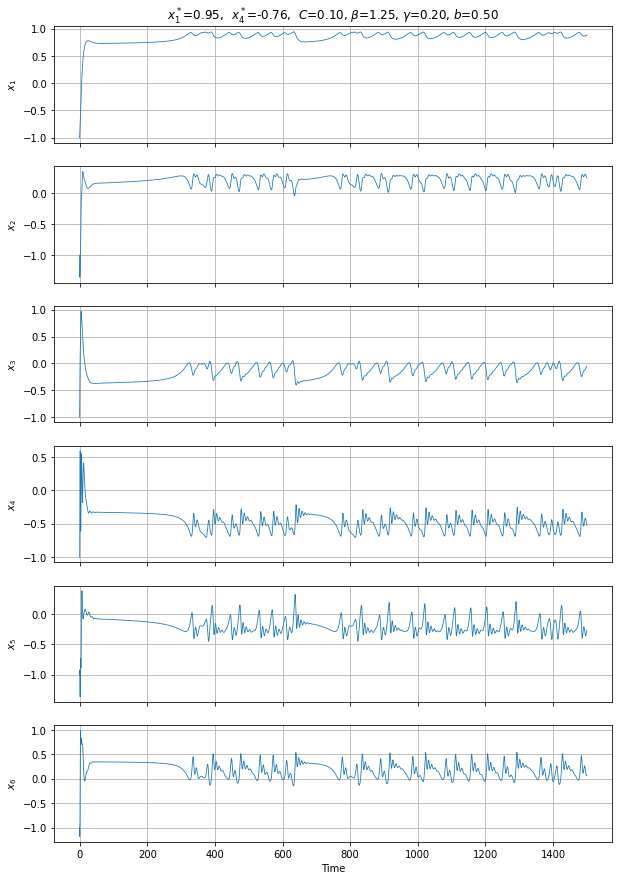

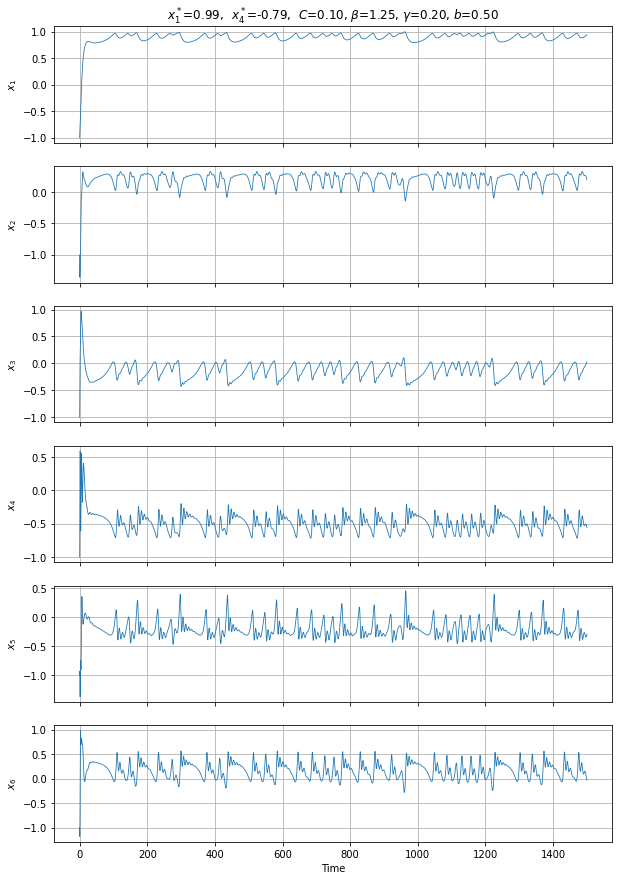

In [14]:
n = len(boundary_idx_arr)
# '''
num_cols = 1
num_rows = 6

factor = 1

prev_idx = 0
for i in range(len(boundary_idx_arr)):
    fig, ax = plt.subplots(6, 1, sharex=True, figsize=(factor*10*num_cols, factor*2.5*num_rows))
    ax_ylabels = ['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', '$x_6$']
    input_time = np.arange(0, N+1)*delta_t
    for j in range(6):
        ax[j].plot(input_time, all_data[i*(N+1):(i+1)*(N+1), j], linewidth=0.8)#, label='_nolegend_')
        ax[j].grid()
        ax[j].set_ylabel(ax_ylabels[j])
        
    # fig.suptitle(r'$x_1^*$={:.2f},  $x_4^*$={:.2f},  $C$={:.2f}, $\beta$={:.2f}, $\gamma$={:.2f}, $b$={:.2f}'.format(
    #     all_data[i*(N+1), 6],
    #     all_data[i*(N+1), 7],
    #     all_data[i*(N+1), 8],
    #     all_data[i*(N+1), 9],
    #     all_data[i*(N+1), 10],
    #     all_data[i*(N+1), 11]
    # ))
    ax[0].set_title(r'$x_1^*$={:.2f},  $x_4^*$={:.2f},  $C$={:.2f}, $\beta$={:.2f}, $\gamma$={:.2f}, $b$={:.2f}'.format(
        all_data[i*(N+1), 6],
        all_data[i*(N+1), 7],
        all_data[i*(N+1), 8],
        all_data[i*(N+1), 9],
        all_data[i*(N+1), 10],
        all_data[i*(N+1), 11]
    ), size=12)
    ax[-1].set_xlabel('Time')
    plt.show()
    print('')
# '''

In [15]:
cutoff_times = np.array([
    400,
    400
])

cutoff_idxs = np.array([int((tt+0.25*delta_t)//delta_t) for tt in cutoff_times])

temp = np.empty(shape=len(boundary_idx_arr), dtype=np.int32)
temp[0] = 0
temp[1:] = boundary_idx_arr[:-1]
initial_x0 = all_data[temp + cutoff_idxs, :]

In [16]:
initial_x0

array([[ 0.8453417 ,  0.24575967, -0.23553927, -0.5026474 , -0.20420438,
         0.19842753,  0.95      , -0.76095   ,  0.1       ,  1.25      ,
         0.2       ,  0.5       ],
       [ 0.93201643,  0.22535394,  0.00312516, -0.53649217, -0.30156335,
         0.00263832,  0.99      , -0.79299   ,  0.1       ,  1.25      ,
         0.2       ,  0.5       ]], dtype=float32)

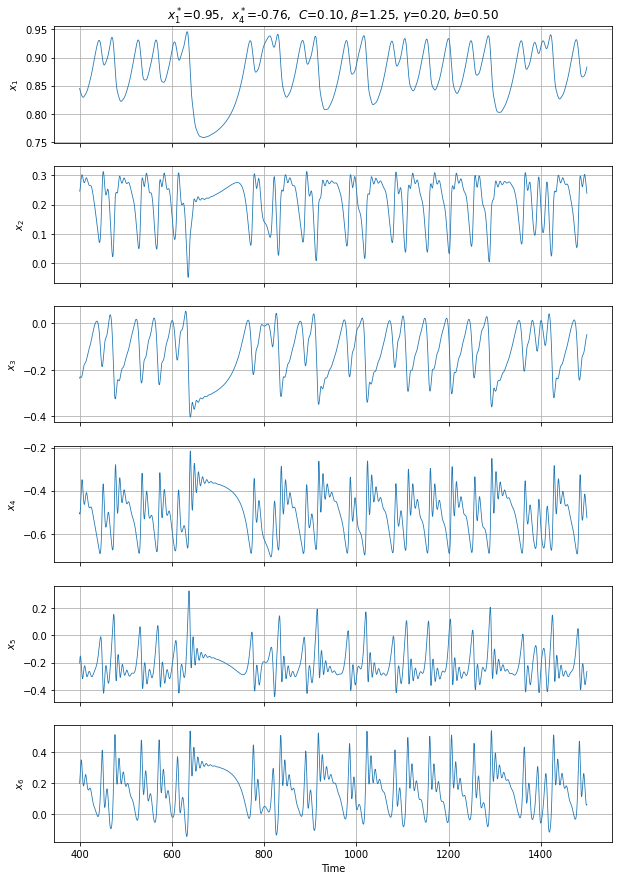

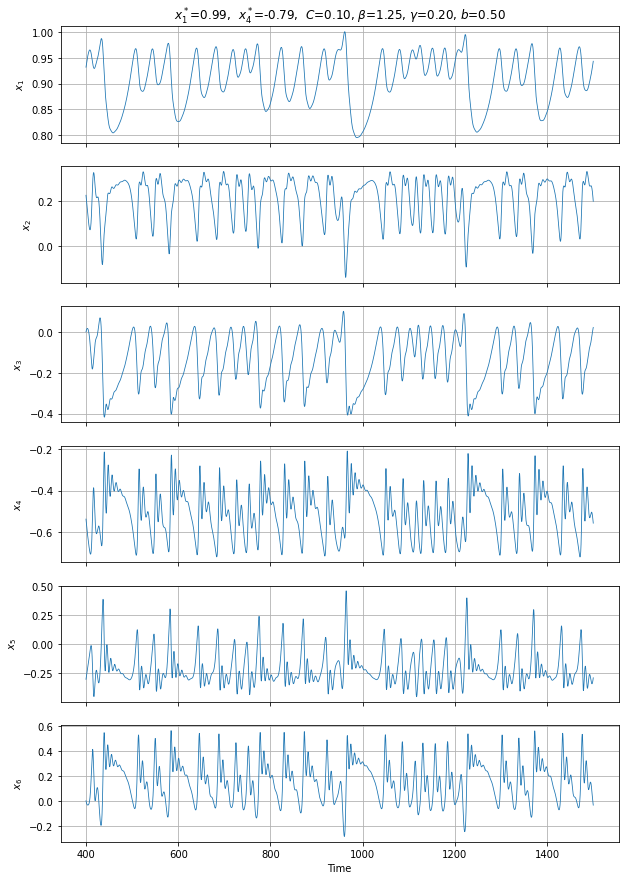

In [17]:
n = len(boundary_idx_arr)
# '''
num_cols = 1
num_rows = 6

factor = 1

prev_idx = 0
for i in range(len(boundary_idx_arr)):
    fig, ax = plt.subplots(6, 1, sharex=True, figsize=(factor*10*num_cols, factor*2.5*num_rows))
    ax_ylabels = ['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', '$x_6$']
    input_time = np.arange(cutoff_idxs[i], N+1)*delta_t
    for j in range(6):
        ax[j].plot(input_time, all_data[i*(N+1) + cutoff_idxs[i]:(i+1)*(N+1), j], linewidth=0.8)#, label='_nolegend_')
        ax[j].grid()
        ax[j].set_ylabel(ax_ylabels[j])
        
    # fig.suptitle(r'$x_1^*$={:.2f},  $x_4^*$={:.2f},  $C$={:.2f}, $\beta$={:.2f}, $\gamma$={:.2f}, $b$={:.2f}'.format(
    #     all_data[i*(N+1), 6],
    #     all_data[i*(N+1), 7],
    #     all_data[i*(N+1), 8],
    #     all_data[i*(N+1), 9],
    #     all_data[i*(N+1), 10],
    #     all_data[i*(N+1), 11]
    # ))
    ax[0].set_title(r'$x_1^*$={:.2f},  $x_4^*$={:.2f},  $C$={:.2f}, $\beta$={:.2f}, $\gamma$={:.2f}, $b$={:.2f}'.format(
        all_data[i*(N+1), 6],
        all_data[i*(N+1), 7],
        all_data[i*(N+1), 8],
        all_data[i*(N+1), 9],
        all_data[i*(N+1), 10],
        all_data[i*(N+1), 11]
    ), size=12)
    ax[-1].set_xlabel('Time')
    plt.show()
    print('')
# '''

In [18]:
def computing_lpexp(
        x, y, N, delta_t, num_search_points_lmda,
        num_points_toskip_lmda, lmda_tol):

    if num_search_points_lmda is None and num_points_toskip_lmda is not None:
        arr = np.arange(0, N+1, num_points_toskip_lmda)
    elif num_search_points_lmda is not None and num_points_toskip_lmda is None:
        arr = np.linspace(0, N, num_search_points_lmda, dtype=np.int32)
    prev_lambda = 0.0
    last_j = None
    for j in arr:
        coeffs = np.polyfit(x[j:], y[j:], deg=1)
        new_lambda = coeffs[0]
        if j == 0:
            prev_lambda = new_lambda
            # pass
        elif np.absolute(prev_lambda-new_lambda) < lmda_tol:
            print('j : {}'.format(j))
            last_j = j
            break
        else:
            prev_lambda = new_lambda
    if last_j is None:
        print('recursion')
        temp_num_search_points_lmda = None
        temp_num_points_toskip_lmda = None
        if num_search_points_lmda is not None:
            temp_num_search_points_lmda = 2*num_search_points_lmda
        if num_points_toskip_lmda is not None:
            temp_num_points_toskip_lmda = int(0.5*num_points_toskip_lmda)
        coeffs, new_coeffs, last_j = computing_lpexp(
            x, y, N, delta_t, temp_num_search_points_lmda,
            temp_num_points_toskip_lmda, lmda_tol)
        
    new_coeffs = np.polyfit(x[0:last_j], y[0:last_j], deg=1)
    return coeffs, new_coeffs, last_j



def find_lyapunov_exponents(
        og_data_list, Tn, eps, x_idx, delta_t, num_state_var,
        params_mat, cutoff_times,
        initial_x0, create_data_func, lmda_tol=1e-6,
        num_search_points_lmda=None, num_points_toskip_lmda=20):

    
    if num_search_points_lmda is None and num_points_toskip_lmda is None:
        raise ValueError('incorrect arguments')
    if num_search_points_lmda is not None and num_points_toskip_lmda is not None:
        raise ValueError('incorrect arguments')

    lambda_arr = np.empty(shape=(params_mat.shape[0], 5))

    ax_list = []

    for i in range(params_mat.shape[0]):
        print('------ i : {} ------'.format(i))
        t0 = cutoff_times[i]
        pm = params_mat[None, i]
        ## og data
        data_og = og_data_list[i]
        ## eps perturbed data
        init_state = initial_x0[i, 0:num_state_var].copy()
        init_state[x_idx] += eps
        res_dict = create_data_func(
            Tn+t0, t0, delta_t,
            pm,
            init_state, return_params_arr=False,
            normalize=False
        )
        data_perturbed = res_dict['all_data']
        N = res_dict['N']
        ## exponent calculation
        diff_norm = np.linalg.norm(data_perturbed - data_og, axis=1)
        y = np.log(diff_norm / eps)
        x = np.arange(0, N+1)*delta_t
        coeffs, new_coeffs, last_j = computing_lpexp(
            x, y, N, delta_t, num_search_points_lmda,
            num_points_toskip_lmda, lmda_tol)
        lmda = new_coeffs[0]
        print('i : {}, lambda : {}'.format(i, lmda))

        lambda_arr[i, 0:2] = new_coeffs
        lambda_arr[i, 2:4] = coeffs
        lambda_arr[i, 4] = last_j

        fig, ax = plt.subplots()
        ax.plot(t0+x[0:last_j], new_coeffs[0]*x[0:last_j] + new_coeffs[1], linewidth=0.8, color='C0')
        ax.plot(t0+x[last_j:], coeffs[0]*x[last_j:] + coeffs[1], linewidth=0.8, color='C0')
        ax.plot(t0+x, y, color='C1')
        ax.set_xlabel('Time')
        ax.set_ylabel(r'$\| ln \left( X(x_0+\epsilon) - X(x_0) \| \ / \ \| \epsilon \| \right)$')
        ax.grid()
        # plt.show()
        ax_list.append((fig, ax))
        plt.show()
        print('-'*19 + '\n')
        # plt.clf()

    return lambda_arr, ax_list


In [19]:
Tn = 1500
eps_arr = np.array([1e-3, 1e-4, 1e-5, 1e-6])
x_idx_arr = np.arange(6)
num_state_var = 6
create_data_func = create_CDV_data

*****************************************
---------------eps : 0.001---------------
*****************************************

----------x_idx : 0----------
------ i : 0 ------
j : 13000
i : 0, lambda : 0.04847038527891763


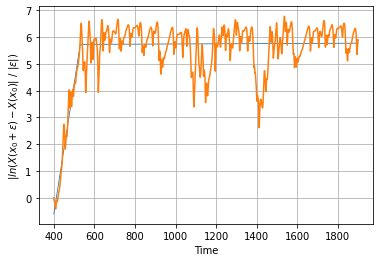

-------------------

------ i : 1 ------
j : 20600
i : 1, lambda : 0.028287981518844946


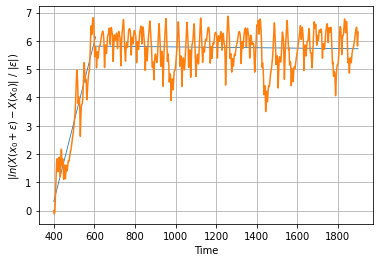

-------------------

-----------------------------

----------x_idx : 1----------
------ i : 0 ------
j : 19200
i : 0, lambda : 0.03907864736173415


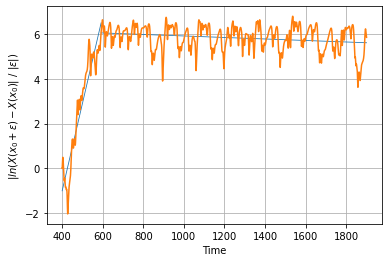

-------------------

------ i : 1 ------
j : 24200
i : 1, lambda : 0.011830173948300505


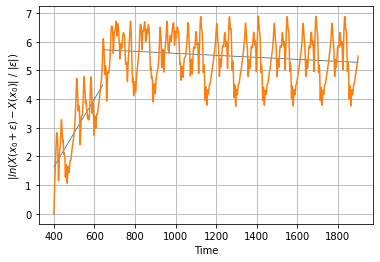

-------------------

-----------------------------

----------x_idx : 2----------
------ i : 0 ------
j : 11200
i : 0, lambda : 0.050706143171951885


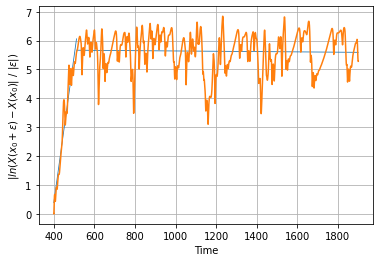

-------------------

------ i : 1 ------
j : 9800
i : 1, lambda : 0.031806839322626346


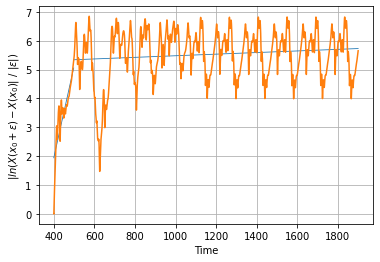

-------------------

-----------------------------

----------x_idx : 3----------
------ i : 0 ------
j : 12200
i : 0, lambda : 0.052234343396551135


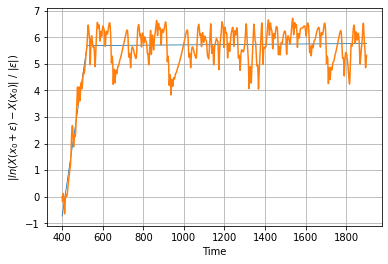

-------------------

------ i : 1 ------
j : 11400
i : 1, lambda : 0.02905144044660774


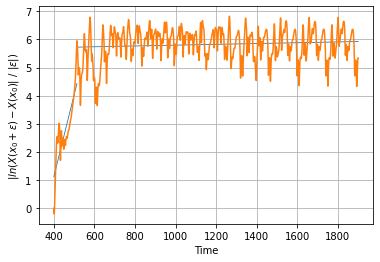

-------------------

-----------------------------

----------x_idx : 4----------
------ i : 0 ------
j : 10800
i : 0, lambda : 0.05799870618183272


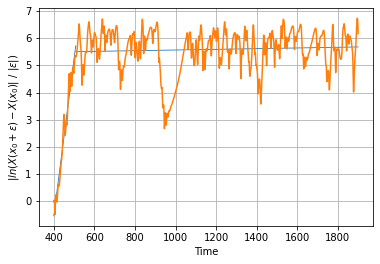

-------------------

------ i : 1 ------


KeyboardInterrupt: ignored

In [20]:
big_mat = np.empty(shape=(eps_arr.shape[0], x_idx_arr.shape[0], params_mat.shape[0], 5))

og_data_list = []
for i in range(params_mat.shape[0]):
    t0 = cutoff_times[i]
    pm = params_mat[None, i]
    init_state = initial_x0[i, 0:num_state_var].copy()
    res_dict = create_data_func(
        Tn+t0, t0, delta_t,
        pm,
        init_state, return_params_arr=False,
        normalize=False
    )
    data_og = res_dict['all_data']
    og_data_list.append(data_og)

ax_mat = []
for eps_i in range(len(eps_arr)):
    eps = eps_arr[eps_i]
    eps_s = '-'*15 + 'eps : {}'.format(eps) + '-'*15
    print('*'*len(eps_s))
    print(eps_s)
    print('*'*len(eps_s) + '\n')

    ax_mat2 = []
    for x_idx_j in range(len(x_idx_arr)):
        x_idx = x_idx_arr[x_idx_j]
        x_idx_s = '-'*10 + 'x_idx : {}'.format(x_idx) + '-'*10
        print(x_idx_s)
        lambda_arr, ax_list = find_lyapunov_exponents(
            og_data_list, Tn, eps, x_idx, delta_t, num_state_var,
            params_mat, cutoff_times,
            initial_x0, create_data_func, lmda_tol=1e-6, num_points_toskip_lmda=200)
        big_mat[eps_i, x_idx_j, :, :] = lambda_arr[:, :]
        ax_mat2.append(ax_list)
        print('-'*len(x_idx_s) + '\n')
    ax_mat.append(ax_mat2)

In [ ]:
# for eps_i in range(len(eps_arr)):
#     eps = eps_arr[eps_i]
#     ax_mat2 = ax_mat[eps_i]
#     for x_idx_j in range(len(x_idx_arr)):
#         x_idx = x_idx_arr[x_idx_j]

#         figax_list = ax_mat2[x_idx_j]

#         for k in range(params_mat.shape[0]):
#             fig, ax = figax_list[k]
#             ax.set_ylabel(r'$\| ln \left( X(x_0+\epsilon) - X(x_0) \| \ / \ \| \epsilon \| \right)$')
#             fig.savefig('eps_i : {}, x_idx_j : {}, pm_case : {}.png'.format(eps_i, x_idx_j, k), dpi=300, bbox_inches='tight')

In [ ]:
# np.save('lpexp_fit_coeffs', big_mat)